# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2001,2022)    #(1997,2021) # Set years to download

In [2]:
import os
datapath = os.path.join('../')
#print('datapath is set to %s'%datapath)

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly 
# !pip install cufflinks
#!pip install colorspacious
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
import matplotlib.dates as mdates

## groundwater calculations and write to file

In [3]:
#new location put 88
dir = '../Dinoloket_2024-01-20/Grondwaterstanden_Put/B32F0088001_1_edit.csv'
df_GWS=pd.read_csv(dir,sep=",",index_col=False)
df_GWS=df_GWS.drop(['Locatie','Filternummer','Bijzonderheid','Opmerking'], axis=1)
#df_GWS['Peildatum']=df_GWS['Peildatum']+" 12:00"
df_GWS['datetime']=pd.to_datetime(df_GWS['Peildatum'], dayfirst=True, format='mixed')
df_GWS.index = df_GWS['datetime']
df_GWS=df_GWS.drop(['Peildatum','datetime'], axis=1)
years_range=(str(list(years)[0])+'-01-01',str(list(years)[-1])+'-12-31')
st=years_range[0]
ed=years_range[1]
df_GWS=df_GWS.loc[st:ed,['Stand (cm t.o.v. MV)']]
df_GWS.rename(columns={'Stand (cm t.o.v. MV)':'depth'},inplace=True)


#df_GWS_7d=df_GWS.resample('7D').interpolate()
#avg_GWS_7d = df_GWS_7d['depth'].mean()
#df_GWS_7d['anom']=df_GWS_7d.loc[st:ed,'depth']-avg_GWS_7d
#df_GWS_7d.index=df_GWS_7d.index.astype('datetime64[s]')

In [6]:
df_GWS

,depth
datetime,
2001-01-15,109.0
2001-01-29,107.0
2001-02-14,78.0
2001-02-28,84.0
2001-03-14,85.0
...,...
2019-12-27,249.0
2019-12-28,248.0
2019-12-29,247.0


In [4]:
#up to 18-04-2002 the data is roughly every 14 days. After daily frequency.
df_GWS_daily_2001=df_GWS.loc['2001-01-01':'2002-04-18',['depth']].copy()
#df_GWS_daily_2001.index=df_GWS_daily_2001.index.floor('1D') #if the index has timestamp use this line for .interpolate() to work
df_GWS_daily_2001=df_GWS_daily_2001.resample('1D').interpolate(method='time')
df_GWS_daily_2001=df_GWS_daily_2001.loc[:'2002-04-17'] # remove the date 2002-04-18 for later attachment to rest of dataframe

#create and attach the above interpolated section of df to the rest of the data
df_GWS_daily=pd.DataFrame()
df_GWS_daily=df_GWS.loc['2002-04-18':,['depth']]
#df_GWS_daily.index=df_GWS_daily.index.floor('1D') #need to remove the time
df_GWS_daily=pd.concat([df_GWS_daily_2001,df_GWS_daily],axis=0) #join the two row-wise with concat

avg_GWS_all = df_GWS_daily['depth'].mean()
df_GWS_daily['depth_anom_all'] = df_GWS_daily.loc[st:ed,'depth']-avg_GWS_all

#write data to file

#df_GWS_daily.to_csv('./GWS_daily.csv')

In [8]:
#change since april of that year
#slice up the dataframe into data based on year
#select values between dates of interest (2001-2019)

#create a df that has only the measured values (roughly every 14 days until early 2002)
df_GWS_multi = pd.DataFrame()
df_GWS_multi['yeardate'] = pd.date_range(start="2000-04-01", end="2000-10-30", freq='1D') #using dummy dates for year 2000 because otherwise datetime obj wont work
df_GWS_multi['monthday'] = df_GWS_multi['yeardate'].dt.strftime(date_format='%m-%d')
df_GWS_multi.index=df_GWS_multi['yeardate']

for year in range(2001,2020):
    st=str(year)+'-04-01'
    ed=str(year)+'-10-30'
    df_tmp=df_GWS_daily.loc[st:ed,['depth']]
    df_tmp=df_tmp.rename(columns={'depth':'depth_'+str(year)})
    df_tmp.index=df_tmp.index.strftime(date_format='2000-%m-%d') #set year to 2000 otherwise I can't easily use joins
    df_tmp.index=pd.to_datetime(df_tmp.index)
    #calc difference since april 1
    val_start = df_tmp.loc['2000-04-01','depth_'+str(year)] #the value at april 1st of that year
    df_tmp['depth_'+str(year)+'_diff']=df_tmp['depth_'+str(year)]-val_start #subtract value at april 1st so that it starts at 0
    avg_GWS_season = df_GWS['depth'].mean()
    df_tmp['depth_'+str(year)+'_anom']=df_tmp['depth_'+str(year)]-avg_GWS_season #subtract value at april 1st so that it starts at 0
    #attach temp results to main df
    df_GWS_multi=pd.concat([df_GWS_multi,df_tmp],axis=1)

#from here: https://stackoverflow.com/questions/42138357/pandas-rolling-slope-calculation    
#def calc_slope(x):
#    slope = np.polyfit(range(len(x)), x, 1)[0]
#    return slope

## set min_periods=2 to allow subsets less than 60.
## use [4::5] to select the results you need.
#result = data.rolling(60, min_periods=2).apply(calc_slope)[4::5]
    
#df_GWS_multi

df_GWS_multi.to_csv('./GWS_multi_daily.csv')

In [10]:
#df_GWS_multi

## Groundwater Plots

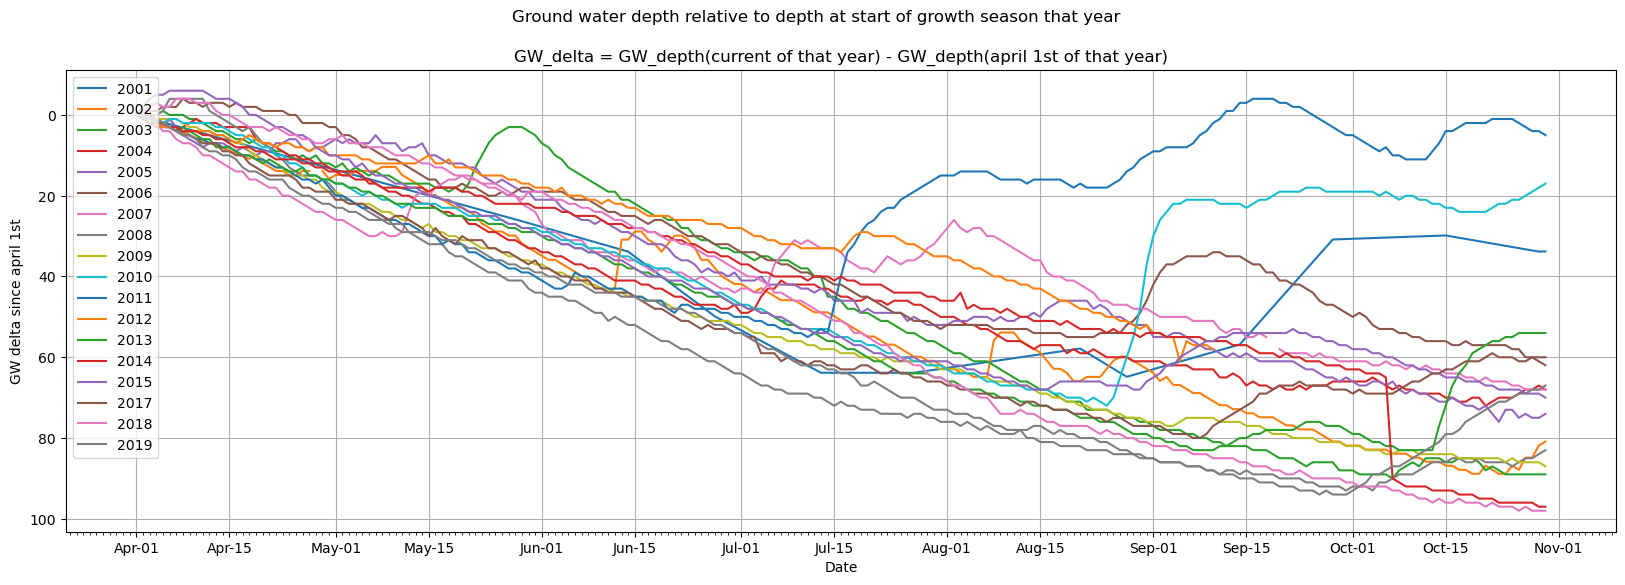

In [11]:
df_GWS_multi # all years

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel('GW delta since april 1st')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)



colored_years={'2003':'green','2006':'orange','2011':'#b62020','2013':'purple','2015':'','2018':'blue'}

for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    if year in colored_years.keys():
        color=colored_years[year]
        marker=''
    else:
        color='grey'
        marker=''
    ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker ,label=year) 
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.grid()

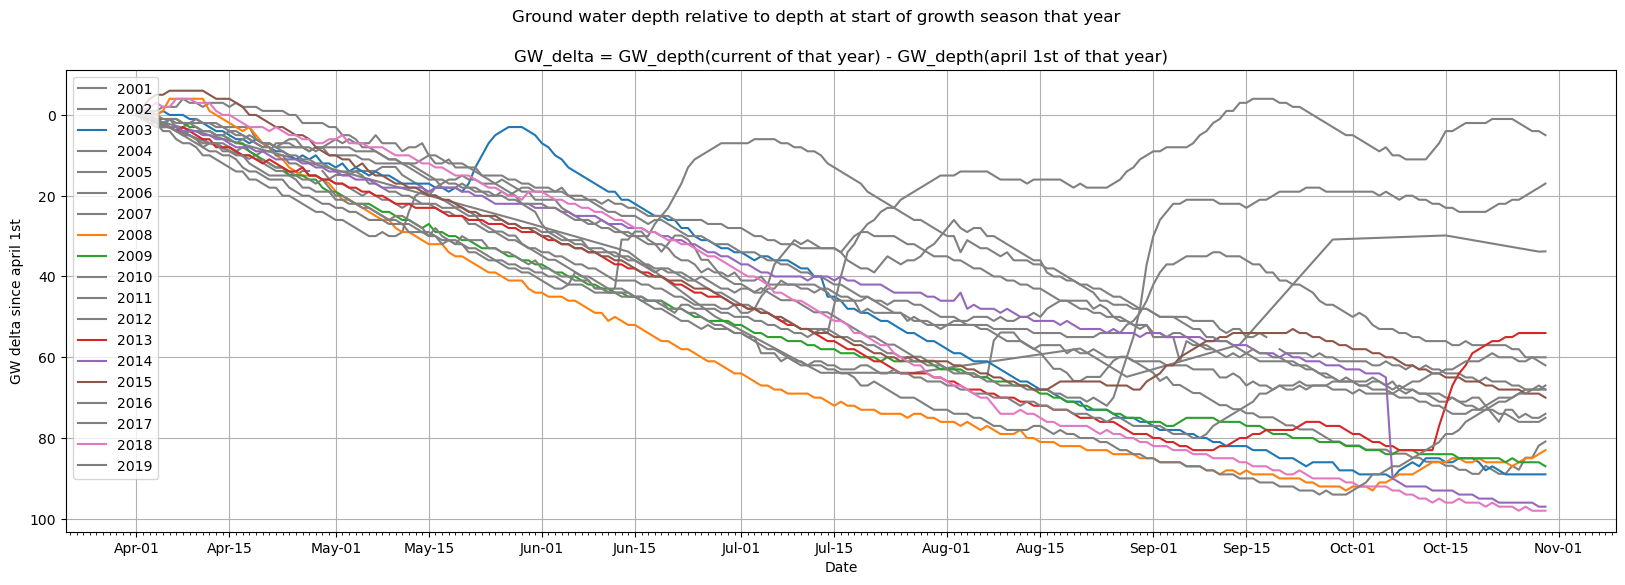

In [12]:
## df_GWS_multi #years that stay down

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel('GW delta since april 1st')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)

#colored_years={'2003':'green','2008':'orange', 2009'2011':'#b62020','2013':'purple','2018':'blue'}
#2003 2008 2009 2010 (2011) 2013 2014  2018 2019

grey_years=['2001','2002','2004','2005','2006','2007','2010','2011','2012','2016','2017']

#
for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    if year in grey_years:#colored_years.keys():
        marker=''
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, color='grey', zorder=3 ,label=year)
    else:
        marker=''
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, zorder=3 ,label=year)
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.grid()

# all years GWS

In [5]:
df_GWS

,depth
datetime,
2001-01-15,109.0
2001-01-29,107.0
2001-02-14,78.0
2001-02-28,84.0
2001-03-14,85.0
...,...
2019-12-27,249.0
2019-12-28,248.0
2019-12-29,247.0


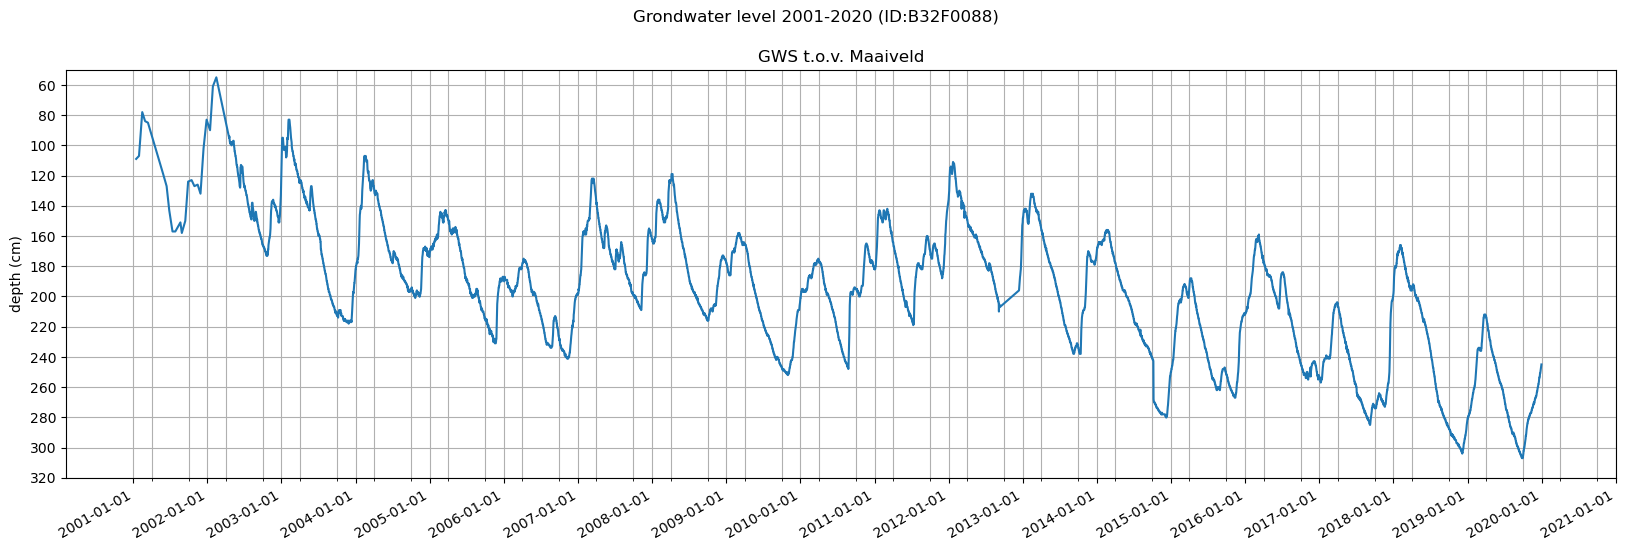

In [5]:
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FixedLocator
#from matplotlib.axis import Axis

plt.rcParams["figure.figsize"] = (20,6)
fig, ax1 =plt.subplots(nrows=1,ncols=1)

ax1.plot(df_GWS['depth'])

ax1.set_ylim(50,320)
ax1.set_title('GWS t.o.v. Maaiveld')
ax1.set_ylabel('depth (cm)')
ax1.invert_yaxis()
fig.suptitle('Grondwater level 2001-2020 (ID:B32F0088)')
years = [datetime(year,1,1) for year in range(2001,2022)]
f1=lambda year: datetime(year,4,1)
f2=lambda year: datetime(year,10,1)
growseasons = [f(year) for year in range(2001,2021) for f in (f1,f2)] #double list comprehension pattern: [f(x) for x in range(5) for f in (f1,f2)]
xticks = [mdates.date2num(z) for z in growseasons]
#Axis.set_major_locator(ax1.xaxis, years)
ax1.yaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.FixedLocator(xticks))
#ax1.yaxis.set_minor_locator(growseasons)
ax1.xaxis.set_ticks(years)
fig.autofmt_xdate() #allows you to auto-align the x axis labels
ax1.grid()
ax1.grid(axis='x', which='minor')

#print(growseasons)

plt.show()